# <div align='center' id="top"> Training for Gender Classification task  </div>

## `Table of contents`

- ###  <a href="#label">Data Labeling</a>
- ###  <a href="#model">Model Building</a>
- ###  <a href="#train">Model Training & Evaluation</a>


### <div align='center' id="label">Data Labeling</div>



<div align = "right"><a href="#top" > Back to top </a></div>

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Constants
IMG_SIZE = (112, 112)
base_dir = "gender_split"
genders = ["male", "female"]
label_map = {"male": 0, "female": 1}

def load_images_from_folder(folder_path, label):
    images = []
    for fname in os.listdir(folder_path):
        if not fname.lower().endswith(".jpg"):
            continue
        img_path = os.path.join(folder_path, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0
        img = np.expand_dims(img, axis=-1)
        images.append((img, label))
    return images

# Step 1: Load training data (from train folders only)
train_data = []
for gender in genders:
    train_folder = os.path.join(base_dir, gender, "train")
    train_data.extend(load_images_from_folder(train_folder, label_map[gender]))

# Step 2: Load testing data (from test folders only)
test_data = []
for gender in genders:
    test_folder = os.path.join(base_dir, gender, "test")
    test_data.extend(load_images_from_folder(test_folder, label_map[gender]))

# Step 3: Shuffle and split test_data into val/test (50% each)
np.random.shuffle(test_data)
X_test_full, y_test_full = zip(*test_data)
X_val, X_test, y_val, y_test = train_test_split(
    np.array(X_test_full), np.array(y_test_full),
    test_size=0.5, stratify=y_test_full, random_state=42
)

# Step 4: Finalize training data
np.random.shuffle(train_data)
X_train, y_train = zip(*train_data)
X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train)

# Output shapes
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape},  y_test:  {y_test.shape}")
print(f"Label map: {label_map}")


X_train: (15912, 112, 112, 1), y_train: (15912,)
X_val:   (2019, 112, 112, 1),   y_val:   (2019,)
X_test:  (2019, 112, 112, 1),  y_test:  (2019,)
Label map: {'male': 0, 'female': 1}


### <div align='center' id="model">Model Building</div>



<div align = "right"><a href="#top" > Back to top </a></div>

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.optimizers import Adam


In [ ]:
def fire_module(x, squeeze_channels, expand_channels, name):
    squeeze = Conv2D(squeeze_channels, (1, 1), activation='relu', padding='same', name=f'{name}_squeeze')(x)
    
    expand1x1 = Conv2D(expand_channels, (1, 1), activation='relu', padding='same', name=f'{name}_expand1x1')(squeeze)
    expand3x3 = Conv2D(expand_channels, (3, 3), activation='relu', padding='same', name=f'{name}_expand3x3')(squeeze)
    
    output = Concatenate(axis=-1, name=f'{name}_concat')([expand1x1, expand3x3])
    return output

def squeezenet(input_shape=(112, 112, 1), num_classes=1):
    inputs = Input(shape=input_shape)

    # Initial Conv
    x = Conv2D(96, (7, 7), strides=(2, 2), padding='same', activation='relu', name='conv1')(inputs)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool1')(x)

    # Fire Modules
    x = fire_module(x, squeeze_channels=16, expand_channels=64, name='fire2')
    x = fire_module(x, squeeze_channels=16, expand_channels=64, name='fire3')
    x = fire_module(x, squeeze_channels=32, expand_channels=128, name='fire4')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool4')(x)

    x = fire_module(x, squeeze_channels=32, expand_channels=128, name='fire5')
    x = fire_module(x, squeeze_channels=48, expand_channels=192, name='fire6')
    x = fire_module(x, squeeze_channels=48, expand_channels=192, name='fire7')
    x = fire_module(x, squeeze_channels=64, expand_channels=256, name='fire8')
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same', name='maxpool8')(x)

    x = fire_module(x, squeeze_channels=64, expand_channels=256, name='fire9')
    x = Dropout(0.5, name='dropout')(x)

    # Final layer for binary or multi-class
    x = Conv2D(num_classes, (1, 1), padding='valid', name='conv_final')(x)
    x = GlobalAveragePooling2D(name='global_avgpool')(x)

    output = Activation('sigmoid', name='output')(x)
    model = Model(inputs, output, name='SqueezeNet_scratch')
    model.summary()
    return model


In [ ]:
def alexnet(input_shape=(112, 112, 1), num_classes=1):
    inputs = Input(shape=input_shape)

    # 1st Convolutional Layer
    x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu', padding='same', name='conv1')(inputs)
    x = BatchNormalization(name='bn1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool1')(x)

    # 2nd Convolutional Layer
    x = Conv2D(256, (5, 5), padding='same', activation='relu', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool2')(x)

    # 3rd Convolutional Layer
    x = Conv2D(384, (3, 3), padding='same', activation='relu', name='conv3')(x)

    # 4th Convolutional Layer
    x = Conv2D(384, (3, 3), padding='same', activation='relu', name='conv4')(x)

    # 5th Convolutional Layer
    x = Conv2D(256, (3, 3), padding='same', activation='relu', name='conv5')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='valid', name='pool5')(x)

    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5, name='dropout1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    # (binary classification)
    x = Dense(num_classes, activation='sigmoid', name='output')(x)

    model = Model(inputs=inputs, outputs=x, name='AlexNet_scratch')
    model.summary()
    return model

### <div align='center' id="train">Model Training & Evaluation</div>



<div align = "right"><a href="#top" > Back to top </a></div>

In [4]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


In [7]:
def train_model(model_fn, X_train, y_train, X_val, y_val,
                learning_rate=0.0001, batch_size=128, epochs=15, patience=5,
                checkpoint_path="best_model.h5"):

    # Build the model
    model = model_fn()

    # Compile model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1)
    checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

    # Train
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop, reduce_lr, checkpoint],
                        verbose=1)

    return model, history


In [8]:
def evaluate_and_plot_results(model_fn, model, history, X_train, y_train, X_test, y_test):
    import numpy as np
    from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    # Final Evaluation
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc   = model.evaluate(X_test, y_test, verbose=0)
    val_acc = history.history['val_accuracy'][-1]
    val_loss = history.history['val_loss'][-1]

    print(f"\nTrain Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Accuracy: {val_acc:.4f}")
    print(f"Test  Loss: {test_loss:.4f} | Test  Accuracy: {test_acc:.4f}")

    # Plot Loss and Accuracy
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(history.history['loss'], label='Train Loss')
    axs[0].plot(history.history['val_loss'], label='Val Loss')
    axs[0].set_title('Loss over Epochs')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Train Acc')
    axs[1].plot(history.history['val_accuracy'], label='Val Acc')
    axs[1].set_title('Accuracy over Epochs')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # Predictions
    y_pred_prob = model.predict(X_test)
    y_pred_classes = (y_pred_prob > 0.5).astype("int32").flatten()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_classes, target_names=['Male', 'Female']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Male', 'Female'])
    disp.plot(cmap='Blues')
    plt.show()


In [ ]:

# Train scratch model
model, history = train_model(model_fn=squeezenet,X_train= X_train,y_train= y_train
                ,X_val= X_val, y_val=y_val, learning_rate=0.0001, 
                batch_size=128, epochs=30, patience=7,checkpoint_path="squeeze_gender.h5")



Model: "SqueezeNet_scratch"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 112, 112, 1)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 56, 56, 96)           4800      ['input_11[0][0]']            
                                                                                                  
 maxpool1 (MaxPooling2D)     (None, 28, 28, 96)           0         ['conv1[0][0]']               
                                                                                                  
 fire2_squeeze (Conv2D)      (None, 28, 28, 16)           1552      ['maxpool1[0][0]']            
                                                                                 

c:\Users\Mahmoud\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 85s 637ms/step - loss: 0.6909 - accuracy: 0.5344 - val_loss: 0.6870 - val_accuracy: 0.5344 - lr: 1.0000e-04
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 0.6389 - accuracy: 0.6335
Epoch 2: val_loss improved from 0.68702 to 0.60503, saving model to b0.h5
125/125 [==============================] - 78s 622ms/step - loss: 0.6389 - accuracy: 0.6335 - val_loss: 0.6050 - val_accuracy: 0.6736 - lr: 1.0000e-04
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 0.5906 - accuracy: 0.6833
Epoch 3: val_loss improved from 0.60503 to 0.57637, saving model to b0.h5
125/125 [==============================] - 77s 619ms/step - loss: 0.5906 - accuracy: 0.6833 - val_loss: 0.5764 - val_accuracy: 0.6994 - lr: 1.0000e-04
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 0.5776 - accuracy: 0.6980
Epoch 4: val_loss improved from 0.57637 to 0.56361, saving model to b0.h5
125/125 [============================


Train Loss: 0.1841 | Train Accuracy: 0.9325
Val   Loss: 0.2326 | Val   Accuracy: 0.9153
Test  Loss: 0.2398 | Test  Accuracy: 0.9173


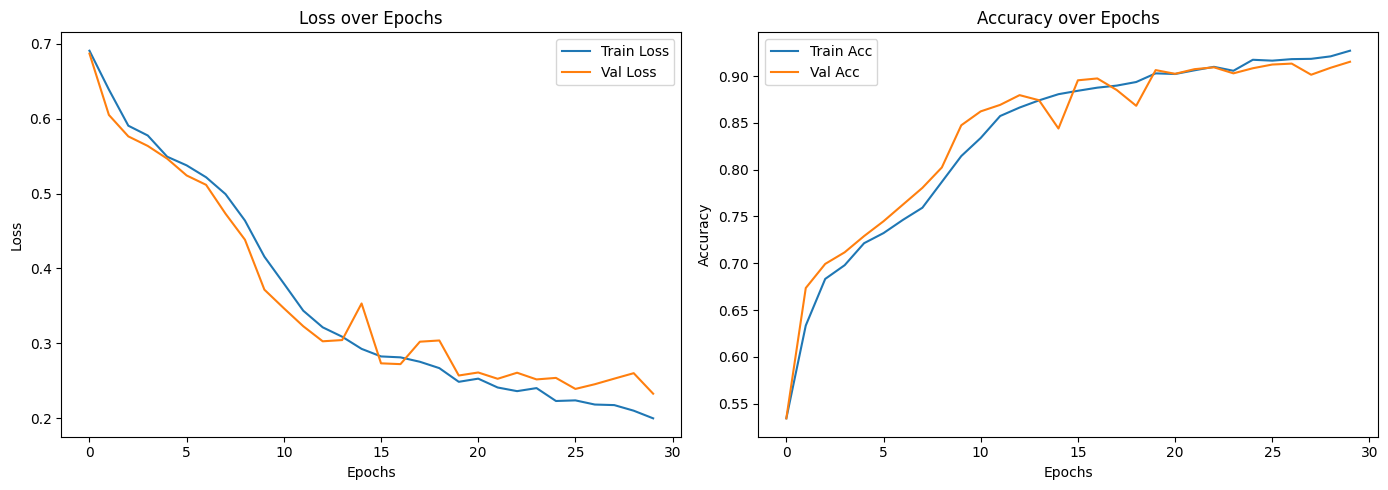

64/64 [==============================] - 3s 49ms/step

Classification Report:
              precision    recall  f1-score   support

        Male       0.91      0.94      0.92      1080
      Female       0.92      0.90      0.91       939

    accuracy                           0.92      2019
   macro avg       0.92      0.92      0.92      2019
weighted avg       0.92      0.92      0.92      2019



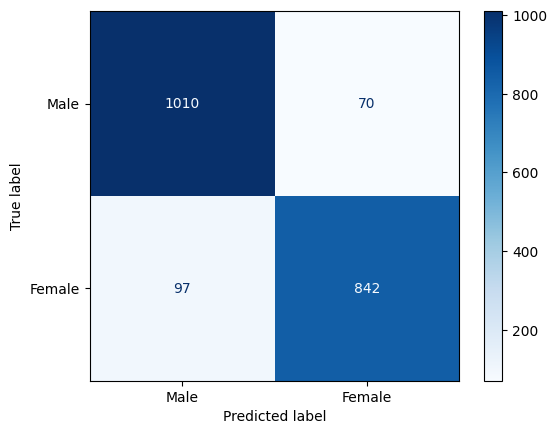

In [ ]:
# Evaluate and visualize
evaluate_and_plot_results(squeezenet,model, history, X_train, y_train, X_test, y_test)

In [ ]:

# Train scratch model
model, history = train_model(model_fn=alexnet,X_train= X_train,y_train= y_train
                ,X_val= X_val, y_val=y_val, learning_rate=0.0001, 
                batch_size=128, epochs=60, patience=7,checkpoint_path="alexnet.h5")


Model: "AlexNet_scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 96)        11712     
                                                                 
 bn1 (BatchNormalization)    (None, 28, 28, 96)        384       
                                                                 
 pool1 (MaxPooling2D)        (None, 13, 13, 96)        0         
                                                                 
 conv2 (Conv2D)              (None, 13, 13, 256)       614656    
                                                                 
 bn2 (BatchNormalization)    (None, 13, 13, 256)       1024      
                                                                 
 pool2 (MaxPooling2D)        (None, 6, 6, 256)     


Train Loss: 0.0962 | Train Accuracy: 0.9722
Val   Loss: 0.2904 | Val   Accuracy: 0.9356
Test  Loss: 0.2194 | Test  Accuracy: 0.9242


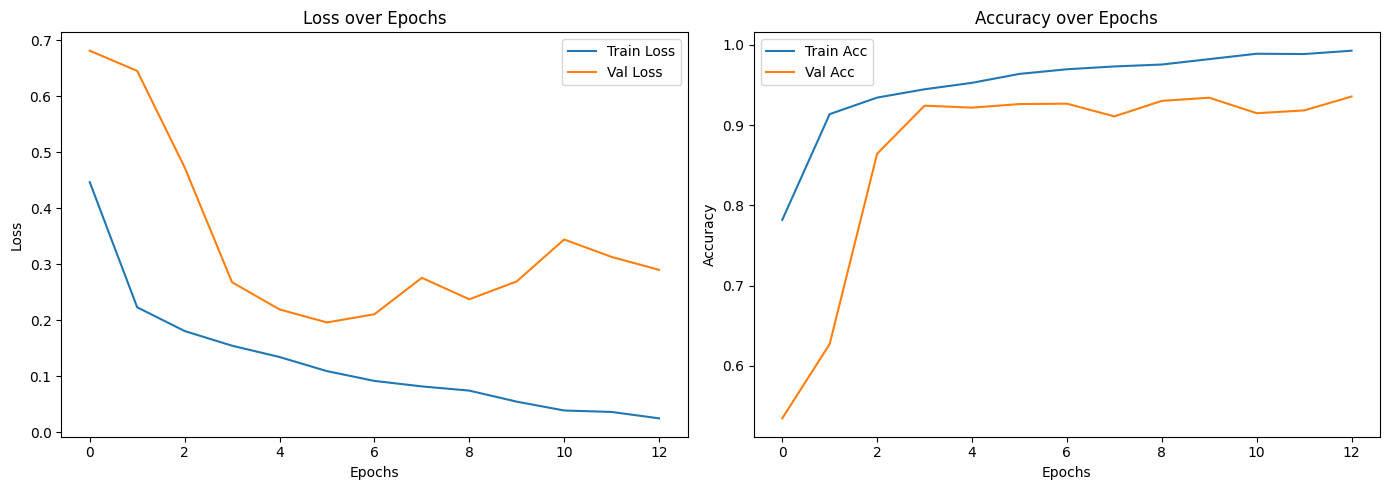

64/64 [==============================] - 3s 49ms/step

Classification Report:
              precision    recall  f1-score   support

        Male       0.94      0.92      0.93      1080
      Female       0.91      0.93      0.92       939

    accuracy                           0.92      2019
   macro avg       0.92      0.92      0.92      2019
weighted avg       0.92      0.92      0.92      2019



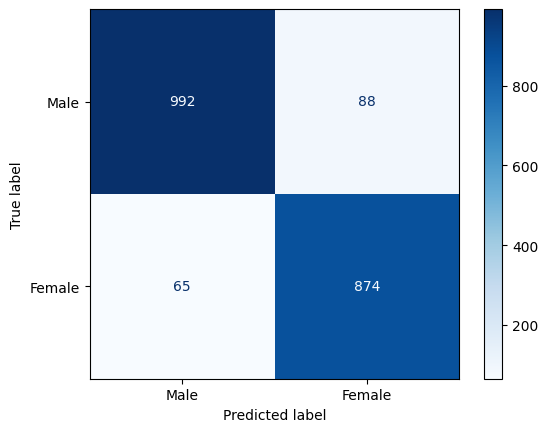

In [12]:
# Evaluate and visualize
evaluate_and_plot_results(alexnet,model, history, X_train, y_train, X_test, y_test)